The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Inputs w\ shape: torch.Size([2, 3, 3, 321, 481])


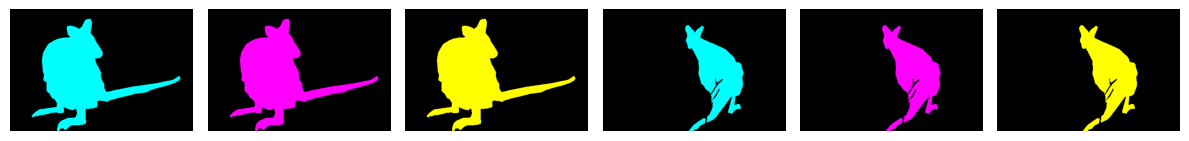

avgs.shape=torch.Size([2, 1, 3, 321, 481])


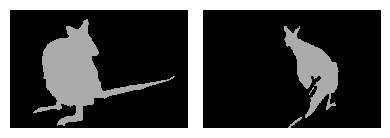

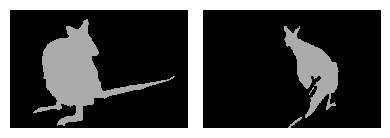

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import sys
import torch
import torch.utils.data as data
import torch.nn as nn
import easydict
import kornia as K


sys.path.append("..")
import utils
import mixmatch
import datasets
import transformations as custom_transforms


# Create SegmentationDatasetLabeled
labeled_dataset = datasets.SegmentationDatasetLabeled(
    dir_images="./my_dataset/images/",
    dir_masks="./my_dataset/masks/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetLabeled
batch_size = 2  # set your desired batch size
labeled_dataloader = data.DataLoader(
    labeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

# Transforamtion
k1 = custom_transforms.GaussianNoiseChannelwise((0.01, 0.02, 0.025))
k2 = K.augmentation.RandomGaussianBlur((3,3),sigma=(5.,5.),p=1)
k3 = K.augmentation.RandomHorizontalFlip(p=1)
k4 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])

img_trans = nn.ModuleList([k1,k2,k3,k4])
mask_trans = nn.ModuleList([k2,k3,k4]) 
invert_trans  = nn.ModuleList([k3,k4])

transform = custom_transforms.MyAugmentation(img_trans,mask_trans,invert_trans)


for img,labels in labeled_dataloader:
    N,C,H,W = labels.shape
    L = 3
    labels =labels.repeat(1, L, 1, 1).reshape(N,L,C,H,W)
    print(f"Inputs w\ shape: {labels.shape}")
    labels[:,0] = utils.set_channel(labels[:,0],0.,0) # zero out red channel
    labels[:,1] = utils.set_channel(labels[:,1],0.,1)
    labels[:,2] = utils.set_channel(labels[:,2],0.,2)
    utils.plot_batch(labels.reshape(N*L,C,H,W))
    averages = mixmatch.average_segmentation_labels(labels,keepshape=False,eps=0.5).reshape(N,C,H,W)
    utils.plot_batch(averages)
    break
